This file is for creating the datasets that we will use for machine learning. 

## Removing duplicates and splitting data

In [1]:
import pandas as pd
import os
from rdkit import Chem
from rdkit.Chem import Descriptors
from collections import Counter
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import numpy as np

seed = 67

# set random seed
random.seed(seed)

pd.set_option('display.max_columns', None)

In [2]:
def go_back_folder():
    current_dir = os.getcwd()
    parent_dir = os.path.dirname(current_dir)
    os.chdir(parent_dir)

def enter_folder(folder_name):
    current_dir = os.getcwd()
    child_dir = os.path.join(current_dir, folder_name)
    os.chdir(child_dir)

# Go back one folder to enter the main folder for the master theises
go_back_folder()

# Go forward to the "Raw data" folder
enter_folder("Raw data")

# Read the Excel file and create the dataframe
df_raw_data = pd.read_excel("Data_from_handbook.xlsx")

# Remove the rows with empty SMILES
df_raw_data = df_raw_data.dropna(subset=['SMILES'])

# Go back to the main folder again
go_back_folder()

# Enter the folder for the code again
enter_folder("Code")

# Print the dataframe
df_raw_data

,NO,FORMULA,NAME,CAS No,A,B,C,TMIN,TMAX,code,SMILES
0,1,CAsCl2F3,dichloro(trifluoro-methyl)arsine,421-32-9,6.44199,1078.1800,222.610,-48.15,108.11,3,C(F)(F)(F)[As](Cl)Cl
1,2,CBrClF2,bromochlorodifluoromethane,353-59-3,6.96434,1008.7093,249.569,-80.45,153.00,"1,2",C(F)(F)(Cl)Br
2,3,CBrCl2F,bromodichlorofluoromethane,353-58-2,7.53163,1515.7000,273.150,-41.09,75.30,"1,2",C(F)(Cl)(Cl)Br
3,4,CBrCl3,bromotrichloromethane,75-62-7,7.17536,1468.7621,238.507,-21.00,131.16,"1,2",C(Cl)(Cl)(Cl)Br
4,5,CBrFO,carbonic bromide fluoride,753-56-0,7.61850,1196.7000,273.150,-92.34,-3.42,3,C(=O)(F)Br
...,...,...,...,...,...,...,...,...,...,...,...
24988,24989,C89H180S,1-nonaoctacontanethiol,66327-04-6,6.69191,3105.9535,62.293,483.39,822.58,3,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
24989,24990,C90H174,tetraoctacontyl-benzene,66327-05-7,6.51412,2732.8134,8.000,487.60,812.11,3,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
24994,24995,C94H190,n-tetranonacontane,1574-32-9,7.18198,2716.0271,-76.300,515.65,755.28,2,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
24998,24999,C98H198,n-octanonacontane,7670-26-0,7.12905,2702.6764,-80.900,521.86,765.61,2,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...


This dataframe might contain SMILES duplicates due to cis/trains. We have to remove these from the dataset. The code below does this the following way:

- If there are multiple compounds with the same SMILES, it keeps the vapor pressure with the highest accuracy. 
- If there are multiple compounds with the highest accuracy, it will pick one randomly. 

In [3]:
# Create a main dataframe that will be used for all the analysis
main_dataframe = df_raw_data.copy()

# Checks how many rows have the same SMILES
duplicated_smiles = main_dataframe[main_dataframe.duplicated(subset='SMILES', keep=False)]

def count_smiles_duplicates(dataframe):
    """
    Count how many times a SMILES value is present in a dataframe.
    """
    duplicates_count = dataframe["SMILES"].value_counts()
    return duplicates_count

# Creates a dictionary with the code values as keys and their importance as values. Lower is better. 
code_importance = {"1": 1, "1,2": 2, "2": 3, "2,3": 4, "3": 5}

# Count how many times a SMILES value is present in the dataframe
duplicates_count = count_smiles_duplicates(duplicated_smiles)

def remove_duplicates_from_dataframe(df, duplicates_count, code_importance):
    for index, count in duplicates_count.items():
        matching_rows = duplicated_smiles[duplicated_smiles["SMILES"] == index]
        lowest_code_rows = []
        lowest_code_value = 10

        # Identifies all the rows with the lowest code value. Here, "2,3" and "2" will be both be identified as the lowest code value.
        for index, row in matching_rows.iterrows():
            row_code_value = row["code"]

            if code_importance[row_code_value] < lowest_code_value:
                lowest_code_rows = []
                lowest_code_value = code_importance[row_code_value]
                lowest_code_rows.append(row)
            
            elif code_importance[row_code_value] == lowest_code_value:
                lowest_code_rows.append(row)
            
        # Now that we have all the lowest code values, we would like to keep only one of them. Which one we will keep 
        # should be chosen randomly.
        random_index = random.randint(0, len(lowest_code_rows) - 1)
        chosen_row = lowest_code_rows[random_index]

        # Remove the chosen row from the lowest code rows, so that we don't drop it later on.
        matching_rows = matching_rows.drop(chosen_row.name, inplace=False)

        # Drop all the other rows with the same SMILES value from df
        df = df.drop(matching_rows.index, inplace=False)

    return df
    
main_dataframe = remove_duplicates_from_dataframe(main_dataframe, duplicates_count, code_importance)
main_dataframe

,NO,FORMULA,NAME,CAS No,A,B,C,TMIN,TMAX,code,SMILES
0,1,CAsCl2F3,dichloro(trifluoro-methyl)arsine,421-32-9,6.44199,1078.1800,222.610,-48.15,108.11,3,C(F)(F)(F)[As](Cl)Cl
1,2,CBrClF2,bromochlorodifluoromethane,353-59-3,6.96434,1008.7093,249.569,-80.45,153.00,"1,2",C(F)(F)(Cl)Br
2,3,CBrCl2F,bromodichlorofluoromethane,353-58-2,7.53163,1515.7000,273.150,-41.09,75.30,"1,2",C(F)(Cl)(Cl)Br
3,4,CBrCl3,bromotrichloromethane,75-62-7,7.17536,1468.7621,238.507,-21.00,131.16,"1,2",C(Cl)(Cl)(Cl)Br
4,5,CBrFO,carbonic bromide fluoride,753-56-0,7.61850,1196.7000,273.150,-92.34,-3.42,3,C(=O)(F)Br
...,...,...,...,...,...,...,...,...,...,...,...
24988,24989,C89H180S,1-nonaoctacontanethiol,66327-04-6,6.69191,3105.9535,62.293,483.39,822.58,3,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
24989,24990,C90H174,tetraoctacontyl-benzene,66327-05-7,6.51412,2732.8134,8.000,487.60,812.11,3,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
24994,24995,C94H190,n-tetranonacontane,1574-32-9,7.18198,2716.0271,-76.300,515.65,755.28,2,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...
24998,24999,C98H198,n-octanonacontane,7670-26-0,7.12905,2702.6764,-80.900,521.86,765.61,2,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...


In [4]:
def antoine_equation(A, B, C, temperature):
    log_P = A - (B / (temperature + C))
    return log_P

In [5]:
# Only interested in compounds with computable vapor pressures in the interval 40-135ºC. 
main_dataframe = main_dataframe[(main_dataframe['TMIN'] <= 135) & (main_dataframe['TMAX'] >= 40)]

# Only want the dataframe to contain some of the columns. 
main_dataframe = main_dataframe[['NAME', 'CAS No', 'SMILES', 'code', 'A', 'B', 'C', 'TMIN', 'TMAX']]
main_dataframe

,NAME,CAS No,SMILES,code,A,B,C,TMIN,TMAX
0,dichloro(trifluoro-methyl)arsine,421-32-9,C(F)(F)(F)[As](Cl)Cl,3,6.44199,1078.1800,222.610,-48.15,108.11
1,bromochlorodifluoromethane,353-59-3,C(F)(F)(Cl)Br,"1,2",6.96434,1008.7093,249.569,-80.45,153.00
2,bromodichlorofluoromethane,353-58-2,C(F)(Cl)(Cl)Br,"1,2",7.53163,1515.7000,273.150,-41.09,75.30
3,bromotrichloromethane,75-62-7,C(Cl)(Cl)(Cl)Br,"1,2",7.17536,1468.7621,238.507,-21.00,131.16
5,bromotrifluoromethane,75-63-8,C(F)(F)(F)Br,"1,2",6.96895,800.4823,253.656,-119.55,67.00
...,...,...,...,...,...,...,...,...,...
18609,"2,2,4,4,6,8,8-heptamethylnonane",4390-04-9,CC(CC(C)(C)C)CC(C)(C)CC(C)(C)C,"1,2",7.45625,1985.4767,187.593,119.94,276.91
19918,"1,2,4,5-tetraisopropylbenzene",635-11-0,CC(C)C1=CC(=C(C=C1C(C)C)C(C)C)C(C)C,2,5.84573,1507.6642,184.062,127.00,382.00
19920,"1,3,5-tri-tert-butylbenzene",1460-02-2,CC(C)(C)C1=CC(=CC(=C1)C(C)(C)C)C(C)(C)C,2,5.66836,1425.9142,187.093,118.00,386.00
20951,"4,9-dipropyldodecane",900000-07-9,CCCC(CCC)CCCCC(CCC)CCC,2,6.51614,1746.0115,184.118,132.00,340.00


We now want to see which atoms that are present in this dataset. First step is to create a function that is able to identify the compounds present in a SMILES structure. 

In [6]:
def get_unique_atoms_in_SMILES(smiles):
    """
    This function returns a dictionary with an overview of the unique atoms present in the provided dataset.
    Each unique atom type is counted once per molecule, regardless of how many times it appears in that molecule.
    """
    # Initialize a Counter object to hold our atom counts
    atom_counts = Counter()

    # Convert the SMILES string to an RDKit molecule
    mol = Chem.MolFromSmiles(smiles)
    # If the molecule is valid, proceed
    if mol:
        # Add hydrogens explicitly
        mol = Chem.AddHs(mol)
        # Create a set of unique atoms for this molecule
        unique_atoms = set(atom.GetSymbol() for atom in mol.GetAtoms())
        # Update the atom counts with the unique atoms in this molecule
        atom_counts.update(unique_atoms)

    # Create a dictionary to store the atom counts
    atom_counts_dict = dict(atom_counts)
    return atom_counts_dict

Now, it is possible to create a function to identify all the compounds present in the dataset. We would also like this function to say something about how many times that compound is present.   

In [7]:
def get_unique_atoms_in_data(data):
    """
    This function returns a dictionary with an overview of the unique atoms present in the provided dataset.
    Each unique atom type is counted once per molecule, regardless of how many times it appears in that molecule.
    """
    # Initialize a Counter object to hold our atom counts
    atom_counts = Counter()

    # Iterate over each SMILES string in the dataset
    for smiles in data['SMILES']:
        # Get the unique atoms in the SMILES string
        atom_counts_dict = get_unique_atoms_in_SMILES(smiles)
        
        # Update the atom counts with the unique atoms in this molecule
        atom_counts.update(atom_counts_dict.keys())

    # Create a dictionary to store the atom counts
    atom_counts_dict = dict(atom_counts)

    sorted_dict = dict(sorted(atom_counts_dict.items(), key=lambda x: x[1], reverse=True))

    return sorted_dict

unique_atoms_dict = get_unique_atoms_in_data(main_dataframe)
df_unique_atoms = pd.DataFrame.from_dict(unique_atoms_dict, orient='index', columns=['Count'])
df_unique_atoms.T

,C,H,O,Cl,N,F,Br,S,I,Si,P,Se,B,As,Ge,Hg,Al,In,Te,Sn,Fe,Sb,Ni,Cd,Na
Count,7363,7144,2808,1055,975,832,476,457,219,76,25,18,16,13,9,5,4,4,3,2,2,1,1,1,1


Create a bar plot to show this distribution. 

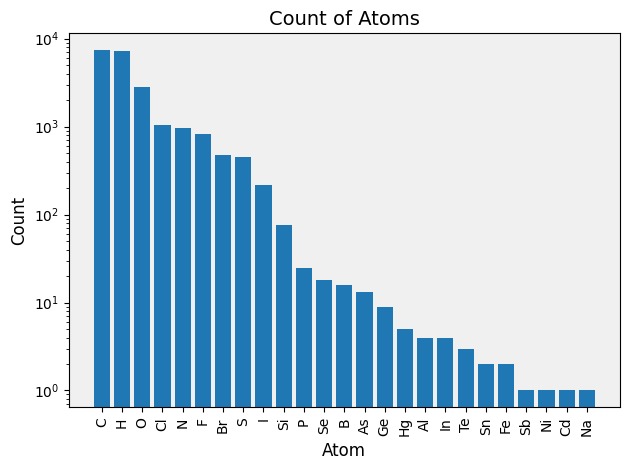

In [8]:
# Create the bar plot
plt.bar(df_unique_atoms.index, df_unique_atoms['Count'])

# Customize the plot
plt.xlabel('Atom', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Count of Atoms', fontsize=14)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)

# Add grid lines

# Make the plot logarithmic
plt.yscale('log')

# Add a background color
plt.gca().set_facecolor('#f0f0f0')

# Adjust the plot layout
plt.tight_layout()

# Show the plot
plt.show()


In [9]:
# Create a new dataframe to store the filtered compounds
filtered_dataframe = pd.DataFrame(columns=main_dataframe.columns)

# Iterate over each compound in the dataset
for index, row in main_dataframe.iterrows():
    # Get the SMILES value of the compound
    smiles = row['SMILES']
    
    # Get the unique atoms in the compound
    atom_counts_dict = get_unique_atoms_in_SMILES(smiles)
    
    # Check if any atom is present that is not in the specified list
    if any(atom not in ['C', 'H', 'O', 'Cl', 'N', 'F', 'Br', 'S', 'I'] for atom in atom_counts_dict.keys()):
        continue  # Skip this compound if it has unwanted atoms
    
    # Add the compound to the filtered dataframe
    filtered_dataframe = pd.concat([filtered_dataframe, row.to_frame().T], ignore_index=True)

df_unique_atoms_filtered = pd.DataFrame.from_dict(get_unique_atoms_in_data(filtered_dataframe), orient='index', columns=['Count'])
df_unique_atoms_filtered.T

,C,H,O,Cl,N,F,Br,S,I
Count,7182,6982,2757,976,961,783,473,441,218


Further, we would like to calculate the valid size of the valid temperature range for all the compounds in the data.

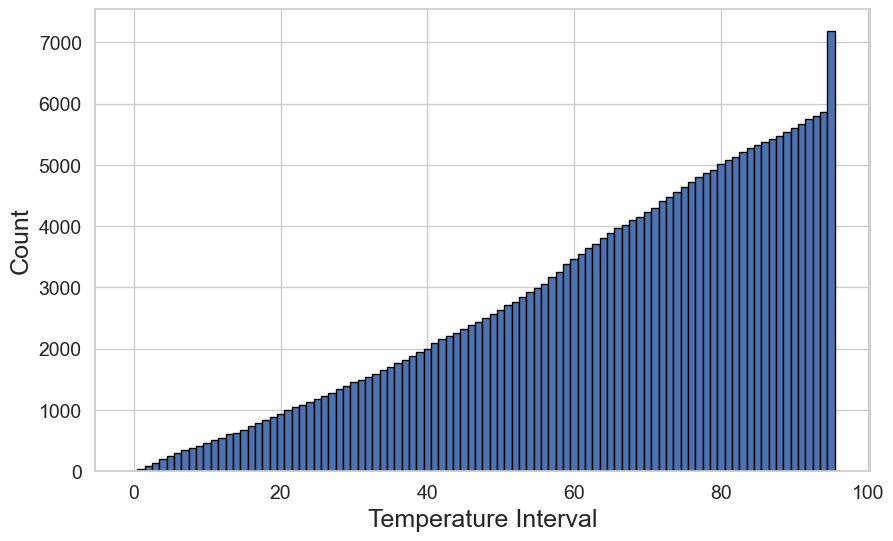

NameError: name 'qwef' is not defined

In [10]:

import seaborn as sns

# Apply the seaborn style default as seen in Google Colab
sns.set(style="whitegrid")


#plt.rcdefaults()

def find_lowest_and_highest_valid_temp(TMIN, TMAX):
    # Check if TMIN is below 40ºC
    if TMIN < 40:
        TMIN = 40

    # Check if TMAX is above 135ºC
    if TMAX > 135:
        TMAX = 135

    return TMIN, TMAX


def calculate_temperature_interval(data):
    # Iterate over each row in the dataframe
    for index, row in data.iterrows():
        # Calculate the temperature range using generate_temperature_range
        TMIN, TMAX = find_lowest_and_highest_valid_temp(row['TMIN'], row['TMAX'])
        
        # Calculate the temperature interval
        temperature_interval = TMAX - TMIN
        
        # Add the temperature interval to the dataframe
        data.at[index, 'Temperature Interval'] = temperature_interval
    
    return data

# Call the function to calculate the temperature interval for each compound in the dataframe
filtered_dataframe = calculate_temperature_interval(filtered_dataframe)

# Create a range of temperature intervals from the minimum to the maximum interval
temperature_intervals = np.arange(filtered_dataframe['Temperature Interval'].min(), 
                                  filtered_dataframe['Temperature Interval'].max() + 1, 1)


# Count the number of compounds with an interval less than the current value. 
# Note that if we set this to <=, we will get a spike at the end of the graph. 
counts_train = [len(filtered_dataframe[filtered_dataframe['Temperature Interval'] <= interval]) for interval in temperature_intervals]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(temperature_intervals, counts_train, width=1, edgecolor='black')
plt.xlabel('Temperature Interval', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title('Distribution of Temperature Intervals', fontsize=18)
enter_folder("Data")
plt.savefig("Temperature_intervals_distribution.png")
go_back_folder()

plt.show()

qwef

Now want to check how many compounds I have before and after removing high molecular weights. 

In [ ]:
# Defines a function that returns the molecular weight of a molecule
def get_molecular_weight(smiles):
    # Create an RDKit molecule object from the SMILES string
    mol = Chem.MolFromSmiles(smiles)
    
    # Calculate the molecular weight of the molecule
    molecular_weight = Chem.Descriptors.MolWt(mol)
    
    return molecular_weight

# Want to add a column with the molecular weight of the compounds
molecular_weights = filtered_dataframe['SMILES'].apply(get_molecular_weight)

# Filter the datasetd to include only compounds with molecular weight lower than 200
molecular_weight_limit = 200
molecular_weights_filtered = molecular_weights[molecular_weights < molecular_weight_limit]

print(len(molecular_weights))
print(len(molecular_weights_filtered))

7182
6268


Want to check how many amines we have in this dataset. 

In [ ]:
def check_if_amine(smiles):
    # Define the SMARTS pattern for amines. 
    primary_and_secondary_amine_smarts = '[NX3;H2,H1;!$(N[C,S]=O)]'
    tertiary_amine_smarts = '[NX3;H0;$(N(C)(C)(C));!$(N[C,S]=O)]'
    
    # Create a molecule object from the SMILES string
    mol = Chem.MolFromSmiles(smiles)
    
    # Have to create the pattern object from the SMARTS string which can then be used for matching
    primary_and_secondary_amine_pattern = Chem.MolFromSmarts(primary_and_secondary_amine_smarts)
    tertiary_amine_pattern = Chem.MolFromSmarts(tertiary_amine_smarts)


    # Apply the SMARTS pattern to the molecule.
    matches_primary_or_secondary = mol.HasSubstructMatch(primary_and_secondary_amine_pattern)
    matches_tertiary = mol.HasSubstructMatch(tertiary_amine_pattern)

    # Return True if the molecule is an amine, and False if it is not.
    if matches_tertiary or matches_primary_or_secondary:
        return True

    return False

# This function returns a dataframe with all the amines present in the inputed dataset

def get_amines_from_data(data):
    # Create an empty dataframe to store the amines
    df_amines = pd.DataFrame(columns=data.columns)

    # Iterate through each compound in training data
    for index, compound in data.iterrows():
        # Check if the compound is an amine
        if check_if_amine(compound['SMILES']):
            # Add the amine compound to the new dataframe
            df_amines = pd.concat([df_amines, compound.to_frame().T])

    return df_amines


# Get the amines from the filtered dataframe
df_amines = get_amines_from_data(filtered_dataframe)
print(f"Total amount of amines in dataset: {df_amines.shape[0]}")

Total amount of amines in dataset: 501


## Run code from here if you need a new dataset

To generate the dataset, we have to define two things: 
1. The size of the minimum temperature interval. For instance 20ºC.
2. The number of temperatures we want to have uniformly in this interval. 

In [ ]:
number_of_temp = 7
min_interval = 20

Now that the dataset only contains the atoms of interest, we would like to split the data into training and testing. If the files already exists, we would like to load the existing files instead

In [ ]:
train_file = "Train.xlsx"
test_file = "Test.xlsx"

train_data = None
test_data = None

# Load train and test data from existing files
enter_folder("Data")
if os.path.exists(train_file) and os.path.exists(test_file):
    train_data = pd.read_excel(train_file)
    test_data = pd.read_excel(test_file)
    go_back_folder()

else:
    # Split the data into training and testing sets
    train_data, test_data = train_test_split(filtered_dataframe, test_size=0.3, random_state=seed)
    train_data.to_excel(train_file, index=False)
    test_data.to_excel(test_file, index=False)
    go_back_folder()

print(f"Total amount of amines in train: {get_amines_from_data(train_data).shape[0]}")
print(f"Total amount of amines in test: {get_amines_from_data(test_data).shape[0]}")
print(f"Corrsponds to a fraction of {get_amines_from_data(train_data).shape[0] / (get_amines_from_data(train_data).shape[0] + get_amines_from_data(test_data).shape[0])} in the training data")

Total amount of amines in train: 351
Total amount of amines in test: 150
Corrsponds to a fraction of 0.7005988023952096 in the training data


Code for producing data at dynamic temperatures:

In [ ]:
def generate_temperatures(TMIN, TMAX, number_of_temp):
    # Check if TMIN is below 40ºC
    if TMIN < 40:
        TMIN = 40

    # Check if TMAX is above 135ºC
    if TMAX > 135:
        TMAX = 135

    # Generate the temperature range using linspace
    temperatures = np.linspace(TMIN, TMAX, number_of_temp)

    return temperatures


def calculate_pressure(data, number_of_temp):

    # Container for storing all the pressure values
    #pressure_values = []
    log_pressure_values = []

    # Iterate over each row in the dataframe
    for index, row in data.iterrows():

        # Extract the temperature range from the dataframe
        temperatures = generate_temperatures(row['TMIN'], row['TMAX'], number_of_temp)
        TMIN = temperatures[0]
        TMAX = temperatures[-1]

        # If the pressure at TMAX is greater than 2 atm, we will decrease the temperature range until it is less than 2 atm
        while (10**antoine_equation(row['A'], row['B'], row['C'], TMAX))/760 > 2:
            # Decrease the temperature range by 1 degree
            TMAX -= 1

            # If the temperature range is less than 40, we will set the temperature interval to 0 and break the loop
            if TMAX <= TMIN+1:
                data.at[index, f'Temperature Interval'] = 0
                break


        # Get the temperature range
        temperatures = generate_temperatures(TMIN, TMAX, number_of_temp)

        # Update the dataframe with the new temperature range
        data.at[index, 'TMIN'] = TMIN
        data.at[index, 'TMAX'] = TMAX
        data.at[index, f'Temperature Interval'] = TMAX - TMIN

        # Calculate the pressure at each temperature using Antoine's equation
        for i, temp in enumerate(temperatures):
            log_pressure = antoine_equation(row['A'], row['B'], row['C'], temp)

            """
            if log_pressure < 1.1:
                # 80 % chance of setting the pressure to NaN
                if random.random() < 0.8:
                    data.at[index, f"T{i+1}"] = pd.NA
                    # Convert the log pressure to pressure
                    #pressure = 10 ** log_pressure
                    log_pressure_values.append(log_pressure)

                else: 
                    data.at[index, f"T{i+1}"] = f"P({temp}) = {log_pressure}"

                    # Convert the log pressure to pressure
                    #pressure = 10 ** log_pressure
                    log_pressure_values.append(log_pressure)

            else:
                data.at[index, f"T{i+1}"] = f"P({temp}) = {log_pressure}"

                log_pressure_values.append(log_pressure)
            """

            data.at[index, f"T{i+1}"] = f"P({temp}) = {log_pressure}"

            log_pressure_values.append(log_pressure)

    # Calculate the mean pressure along with the standard deviation
    mean_pressure = np.mean(log_pressure_values)
    std_pressure = np.std(log_pressure_values)

    return data, mean_pressure, std_pressure

temperature_columns = [f"T{i}" for i in range(1, number_of_temp + 1)]

train_data, mean_pressure_train, std_pressure_train = calculate_pressure(train_data, number_of_temp)
test_data, mean_pressure_test, std_pressure_test = calculate_pressure(test_data, number_of_temp)

We would like to remove all the elements that has a too small temperature interval. 

In [ ]:
# Remove elements with a too small temperature interval from train data
train_data = train_data[train_data['Temperature Interval'] >= min_interval]

# Remove elements with a too small temperature interval from test data
test_data = test_data[test_data['Temperature Interval'] >= min_interval]

# Add the dataframes together
total_dataset = pd.concat([train_data, test_data])

We want to make a plot of the molecular weight distribution. 

Removed 596 compounds from the total dataset
Removed 426 compounds from the train dataset
Removed 170 compounds from the test dataset
Fraction removed from train dataset:  0.714765100671141


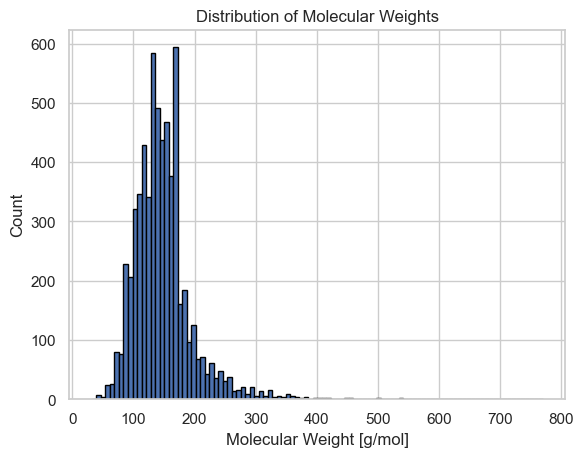

6177
Size of the total dataset: 5581


In [ ]:
# Defines a function that returns the molecular weight of a molecule
def get_molecular_weight(smiles):
    # Create an RDKit molecule object from the SMILES string
    mol = Chem.MolFromSmiles(smiles)
    
    # Calculate the molecular weight of the molecule
    molecular_weight = Chem.Descriptors.MolWt(mol)
    
    return molecular_weight

# Want to add a column with the molecular weight of the compounds
train_data['Molecular Weight'] = train_data['SMILES'].apply(get_molecular_weight)
test_data['Molecular Weight'] = test_data['SMILES'].apply(get_molecular_weight)
total_dataset['Molecular Weight'] = total_dataset['SMILES'].apply(get_molecular_weight)

num_before_filtering_train = len(train_data)
num_before_filtering_test = len(test_data)

# Filter the datasetd to include only compounds with molecular weight lower than 200
molecular_weight_limit = 200
train_data = train_data[train_data['Molecular Weight'] < molecular_weight_limit]
test_data = test_data[test_data['Molecular Weight'] < molecular_weight_limit]
filtered_total_dataset = total_dataset[total_dataset['Molecular Weight'] < molecular_weight_limit]

# Print the amount of compounds removed from each dataset
compounds_removed_from_total = len(total_dataset) - len(filtered_total_dataset)
compounds_removed_from_train = num_before_filtering_train - len(train_data)
compounds_removed_from_test = num_before_filtering_test - len(test_data)

print(f"Removed {compounds_removed_from_total} compounds from the total dataset")
print(f"Removed {compounds_removed_from_train} compounds from the train dataset")
print(f"Removed {compounds_removed_from_test} compounds from the test dataset")
print("Fraction removed from train dataset: ", (compounds_removed_from_train/compounds_removed_from_total))

# Save the plot and this information in the "Min interval 40" folder
enter_folder("Data")

# Try to acess the folder "Min interval: {min_interval} ºC". If it does not exist, create it.
folder_name = f"Min interval of {min_interval} ºC"

# Check if the folder exists
if not os.path.exists(folder_name):
    # Create the folder
    os.makedirs(folder_name)
    
# Enter the folder
enter_folder(folder_name)

# Plot the distribution of molecular weights for the total dataset
plt.hist(total_dataset['Molecular Weight'], bins=100, edgecolor='black')
plt.xlabel('Molecular Weight [g/mol]')
plt.ylabel('Count')
plt.title('Distribution of Molecular Weights')
plt.savefig("Molecular_weights_distribution.png")
plt.show()

with open("Molecular_weights_removed.txt", "w") as file:
    file.write(f"Limit for molecular weight: {molecular_weight_limit} [g/mol]\n")
    file.write(f"Removed {compounds_removed_from_total} compounds from the total dataset\n")
    file.write(f"Removed {compounds_removed_from_train} compounds from the train dataset\n")
    file.write(f"Removed {compounds_removed_from_test} compounds from the test dataset\n")
    file.write("Fraction removed from train dataset: " + str(compounds_removed_from_train/compounds_removed_from_total))
go_back_folder()

total_dataset = filtered_total_dataset

# Print size of the total dataset 
print(num_before_filtering_train + num_before_filtering_test)
print(f"Size of the total dataset: {len(total_dataset)}")

# Want to remove the molecular weight column from the datasets again
train_data = train_data.drop(columns=['Molecular Weight'])
test_data = test_data.drop(columns=['Molecular Weight'])
total_dataset = total_dataset.drop(columns=['Molecular Weight'])

Would like to plot the pressure distribution of the current dataset:

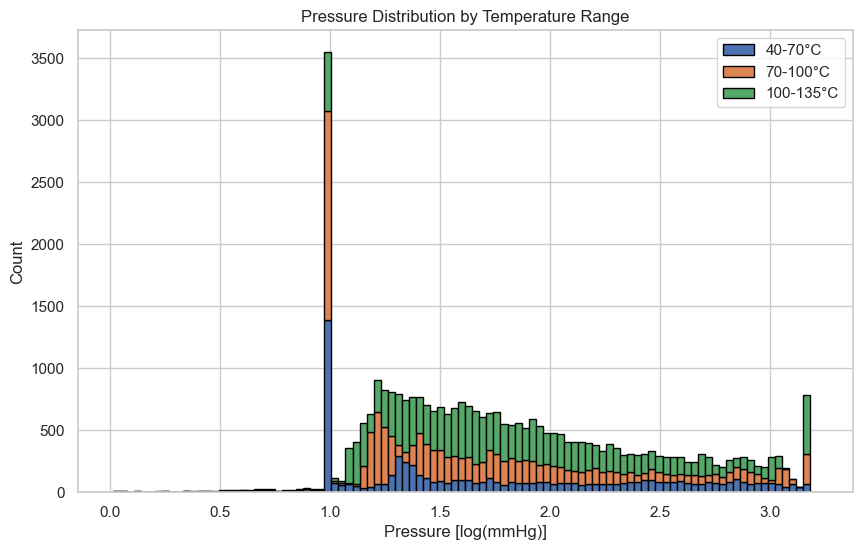

The highest count is 3546
The range of the pressure bin with the highest count is (0.9727963852633662, 1.0048115576096643)


In [ ]:
def get_pressures_from_dataset(dataset):
    # List all temperature columns in the dataset (assuming they follow the 'T1', 'T2', ..., 'Tn' pattern)
    temperature_columns = [col for col in dataset.columns if col.startswith('T') and col[1:].isdigit()]

    pressures_list = []
    temperature_list = []
    smiles_list = []

    # Iterate over each row in the dataset
    for index, row in dataset.iterrows():
        # Iterate over each temperature column
        for col in temperature_columns:
            if not pd.isna(row[col]):  # Check if the value is not NaN
                # Extract the pressure value from the temperature column
                pressure_info = row[col].split('=')[1].strip()
    
                temperature_info = row[col].split('=')[0].strip()
                temperature = float(temperature_info[2:-1])
                temperature_list.append(temperature)

                # Convert the extracted pressure value to float and append it to the pressures list
                pressures_list.append(float(pressure_info))
                smiles_list.append(row['SMILES'])

    return pressures_list, smiles_list, temperature_list

pressures, smiles_list, temperature_list = get_pressures_from_dataset(total_dataset)

#pressures = [(10**pres) for pres in pressures]

#pressures_above_5000 = [pressure for pressure in pressures if pressure > 20000]



"""
import matplotlib.pyplot as plt

# Plot the pressure distribution
plt.hist(pressures, bins=100, edgecolor='black')
plt.xlabel('Pressure [log(mmHg)]')
plt.ylabel('Count')
plt.title('Pressure Distribution')

plt.show()
"""

# Define the temperature ranges
temp_ranges = [(40, 70), (70, 100), (100, 135)]

# Create a list containing all the pressure boundaries for the bins. Each bin will be 1/100 of the total range.
pressure_bins = np.linspace(min(pressures), max(pressures), 100)

# Initialize an empty dictionary to hold our counts and sets of SMILES. 
temperature_counts = {}

# Want to initilize this dictionary with all the necessary keys. Iterate over all the temperature ranges.
for range_key in temp_ranges:
    # For each temperature range, we want a list to hold data for each pressure bin (100 bins)
    range_data = []
    
    # Loop through each pressure bin. 
    for i in range(len(pressure_bins)):
        # Initialize a dictionary for this bin with a count of 0 and an empty set for SMILES
        bin_data = {'count': 0, 'smiles': set()}
        
        # Append this dictionary to our list for the current temperature range
        range_data.append(bin_data)
    
    # Once we've added a dictionary for each pressure bin to our list, 
    # assign this list to the current temperature range key in our main dictionary
    temperature_counts[range_key] = range_data


# Want to iterate over all the pressures, temperatures and smiles.
for pressure, temperature, smiles in zip(pressures, temperature_list, smiles_list):
    # Get the index of the pressure bin for this pressure value. In other words, classify the pressure value into a bin.
    bin_index = np.digitize(pressure, pressure_bins) - 1  # -1 as np.digitize bins are 1-indexed
    # Iterate over all the three temperature ranges
    for temp_range in temp_ranges:
        # Checks if the temperature value is within the range
        if temp_range[0] <= temperature < temp_range[1]:
            # Get the bin data for this temperature range and pressure bin to ensure that the same compound is not counted twice
            # in the same bin.
            bin_data = temperature_counts[temp_range][bin_index]
            if smiles not in bin_data['smiles']:
                # Add the SMILES to the set and increment the count
                bin_data['count'] += 1
                bin_data['smiles'].add(smiles)

# Plotting
plt.figure(figsize=(10, 6))

# Used for stacking the bars on top of each other
bottoms = np.zeros(len(pressure_bins))

# Iterate over each temperature range and store the total counts for each pressure bin
total_counts = []
for temp_range in temp_ranges:
    counts = [bin_data['count'] for bin_data in temperature_counts[temp_range]]
    plt.bar(pressure_bins, counts, bottom=bottoms, label=f'{temp_range[0]}-{temp_range[1]}°C', width=np.diff(pressure_bins)[0], edgecolor='black', align='edge')
    # Update the bottoms for the next temperature range
    bottoms += np.array(counts)
    total_counts.append(counts)

plt.xlabel('Pressure [log(mmHg)]')
plt.ylabel('Count')
plt.title('Pressure Distribution by Temperature Range')
plt.legend()
plt.show()

max_val = 0
index = 0
# Find the maximum value for a bin
for i in range(100): 
    tot_val = total_counts[0][i] + total_counts[1][i] + total_counts[2][i]
    if tot_val > max_val:
        max_val = tot_val
        index = i

# Figure out which pressure range the maximum value is in
pressure_range = pressure_bins[index], pressure_bins[index+1]

# Print the maximum value
print(f"The highest count is {max_val}")

# Print the pressure range
print(f"The range of the pressure bin with the highest count is {pressure_range}")


Below is the overall distribution: 

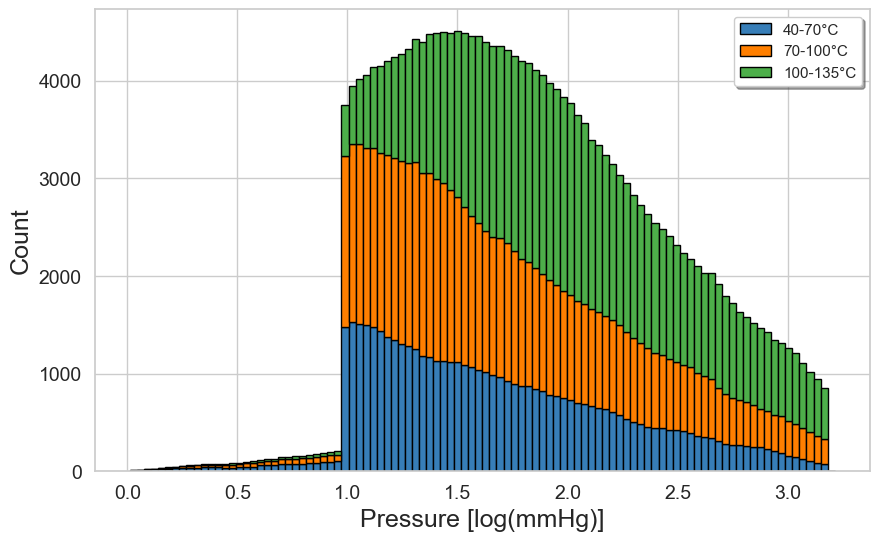

The highest count is 4507
The range of the pressure bin with the highest count is (1.4530239704578376, 1.4850391428041356)


NameError: name 'wecr' is not defined

In [ ]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

# Define the temperature ranges
temp_ranges = [(40, 70), (70, 100), (100, 135)]

# Create a list containing all the pressure boundaries for the bins. Each bin will be 1/100 of the total range.
pressure_bins = np.linspace(min(pressures), max(pressures), 100)

# Initialize an empty dictionary to hold our counts. Should be a dictionary with temperature ranges as keys and a list of bin counts as values.
temperature_counts = {}

# Want to initilize this dictionary with all the necessary keys. Iterate over all the temperature ranges.
for range_key in temp_ranges:

    # Initilize range_data as a list of 0s with a length of 100.
    range_data = [0] * 100

    # Want to assign this list to the current temperature range key in our main dictionary
    temperature_counts[range_key] = range_data


for index, row in total_dataset.iterrows():
    TMIN = row['TMIN']
    TMAX = row['TMAX']
    # Extract the temperature range from the dataframe
    if row['TMIN'] < 40: 
        TMIN = 40

    if row['TMAX'] > 135:
        TMAX = 135

    # Calculate the pressure at TMIN and TMAX
    log_pressure_TMIN = antoine_equation(row['A'], row['B'], row['C'], TMIN)
    bin_index_TMIN = np.digitize(log_pressure_TMIN, pressure_bins) - 1 

    log_pressure_TMAX = antoine_equation(row['A'], row['B'], row['C'], TMAX)
    bin_index_TMAX = np.digitize(log_pressure_TMAX, pressure_bins) - 1 
        

    bin_index_dict = {"bin_index_40":None, "bin_index_70":None, "bin_index_100":None, "bin_index_135":None}
    if TMIN == 40:
        log_pressure_40 = antoine_equation(row['A'], row['B'], row['C'], 40)
        bin_index_dict["bin_index_40"] = np.digitize(log_pressure_40, pressure_bins) - 1 

    if TMIN <= 70 and TMAX >= 70:
        log_pressure_70 = antoine_equation(row['A'], row['B'], row['C'], 70)  
        bin_index_dict['bin_index_70'] = np.digitize(log_pressure_70, pressure_bins) - 1  

    if TMIN <= 100 and TMAX >= 100:
        log_pressure_100 = antoine_equation(row['A'], row['B'], row['C'], 100)
        bin_index_dict['bin_index_100']= np.digitize(log_pressure_100, pressure_bins) - 1 

    if TMAX == 135:
        log_pressure_135 = antoine_equation(row['A'], row['B'], row['C'], 135)
        bin_index_dict['bin_index_135'] = np.digitize(log_pressure_135, pressure_bins) - 1 

    # Want to iterate over all the temperature ranges and add the value to the bins.
    for temp_range in temp_ranges:
        temp_1 = f"{temp_range[0]}"
        temp_2 = f"{temp_range[1]}"

        value_1 = bin_index_dict[f"bin_index_{temp_1}"]
        value_2 = bin_index_dict[f"bin_index_{temp_2}"]

        if value_1 == None and value_2 == None:
            continue

        if value_1 == None and value_2 != None:
            # Want to add the value to all the bins from TMIN and up to the value of value_2
            for i in range(bin_index_TMIN, value_2+1):
                temperature_counts[temp_range][i] += 1

        if value_1 != None and value_2 == None:
            # Want to add the value to all the bins from value_1 and up to TMAX
            for i in range(value_1, bin_index_TMAX+1):
                temperature_counts[temp_range][i] += 1

        if value_1 != None and value_2 != None:
            # Want to add the value to all the bins from value_1 and up to value_2
            for i in range(value_1, value_2+1):
                temperature_counts[temp_range][i] += 1



        
# Plotting
plt.figure(figsize=(10, 6))

# Used for stacking the bars on top of each other
bottoms = np.zeros(len(pressure_bins))

# Iterate over each temperature range and store the total counts for each pressure bin
total_counts = []
for index, temp_range in enumerate(temp_ranges):
    counts = temperature_counts[temp_range]
    plt.bar(pressure_bins, counts, color=CB_color_cycle[index],bottom=bottoms, label=f'{temp_range[0]}-{temp_range[1]}°C', width=np.diff(pressure_bins)[0], edgecolor='black', align='edge')
    # Update the bottoms for the next temperature range
    bottoms += np.array(counts)
    total_counts.append(counts)
plt.xlabel('Pressure [log(mmHg)]', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title('Pressure Distribution by Temperature Range', fontsize=18)
plt.legend(loc='upper right', shadow=True, fancybox=True)
plt.show()

max_val = 0
index = 0
# Find the maximum value for a bin
for i in range(100): 
    tot_val = total_counts[0][i] + total_counts[1][i] + total_counts[2][i]
    if tot_val > max_val:
        max_val = tot_val
        index = i

# Figure out which pressure range the maximum value is in
pressure_range = pressure_bins[index-1], pressure_bins[index]

# Print the maximum value
print(f"The highest count is {max_val}")

# Print the pressure range
print(f"The range of the pressure bin with the highest count is {pressure_range}")

wecr

Want to see if the data is reasonable. We do this by checking the data up against experimental data avilable on pubchem. 

In [ ]:
"""
# Extract the PubChem data from the pubchem_pressures.xlsx file 
pubchem_data = pd.read_excel("pubchem_pressures.xlsx")

X_dev = []
y_dev = []
temp = []

for _, row in pubchem_data.iterrows():
    SMILES = row['SMILES']
    for column in row.index:
        if column == 'SMILES':
            continue
        
        if column.startswith('Pressure'):
            if row[column] is not np.nan:
                # Extracts the temperature and the logP value from the cells. 
                cell_value = row[column].split("=")
                temperature = float(cell_value[0][2:-2])
                logP = float(cell_value[1])

                # Appends the values to the lists.
                X_dev.append(SMILES)
                y_dev.append(logP)
                temp.append(float(temperature))

# Create a dataframe based on total_dataset that only contains the rows with the SMILES values in X_dev
has_pubchem_data = total_dataset[total_dataset['SMILES'].isin(X_dev)]
pressure_in_pubchem = []
pressure_in_book = []
compound_identity = []
code = []

for index, row in has_pubchem_data.iterrows():
    # Get the row with that smile in the has_pubchem_data dataframe
    # Find where the smile is in the X_dev list
    indices = [i for i, x in enumerate(X_dev) if x == row["SMILES"]]
    for i in indices:
        if temp[i] >= row["TMIN"] and temp[i] <= row["TMAX"]:
            A = row["A"]
            B = row["B"]
            C = row["C"]

            pressure_in_book.append(antoine_equation(A, B, C, temp[i]))
            pressure_in_pubchem.append(y_dev[i])
            compound_identity.append( row["SMILES"])
            code.append(row["code"])


# Create parity line 
x = np.linspace(-1.5, 5, 100)
y = x

# Plot the parity line
plt.plot(x, y, '--', label='y=x', color="black")

# Want to plot the pubchem data against the book data.
plt.scatter(pressure_in_pubchem, pressure_in_book)

# Create a dictionary to map numbers to SMILES strings for outliers only
smiles_dict = {}

# Label each point with a number and add outliers to the dictionary
count = 1
for i in range(len(compound_identity)):
    if abs(pressure_in_pubchem[i] - pressure_in_book[i]) > 1:
        plt.annotate(count, (pressure_in_pubchem[i], pressure_in_book[i]), textcoords="offset points", xytext=(0,10), ha='center')
        smiles_dict[count] = compound_identity[i]  # Add outliers to the dictionary
        count += 1  # Increment count
        print(f"Outlier: {compound_identity[i]}, PubChem: {pressure_in_pubchem[i]}, Book: {pressure_in_book[i]}, Code: {code[i]}")

# Create a custom legend for outliers
handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'{i}: {txt}', markerfacecolor='black', markersize=5) for i, txt in smiles_dict.items()]
plt.legend(handles=handles, title='SMILES', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel("Pressure in PubChem [log(mmHg)]")
plt.ylabel("Pressure in book [log(mmHg)]")
plt.title("Pressure in PubChem vs Pressure in book")
plt.show()
"""


'\n# Extract the PubChem data from the pubchem_pressures.xlsx file \npubchem_data = pd.read_excel("pubchem_pressures.xlsx")\n\nX_dev = []\ny_dev = []\ntemp = []\n\nfor _, row in pubchem_data.iterrows():\n    SMILES = row[\'SMILES\']\n    for column in row.index:\n        if column == \'SMILES\':\n            continue\n        \n        if column.startswith(\'Pressure\'):\n            if row[column] is not np.nan:\n                # Extracts the temperature and the logP value from the cells. \n                cell_value = row[column].split("=")\n                temperature = float(cell_value[0][2:-2])\n                logP = float(cell_value[1])\n\n                # Appends the values to the lists.\n                X_dev.append(SMILES)\n                y_dev.append(logP)\n                temp.append(float(temperature))\n\n# Create a dataframe based on total_dataset that only contains the rows with the SMILES values in X_dev\nhas_pubchem_data = total_dataset[total_dataset[\'SMILES\'].isi

To ensure that the data is split in a reasonable way, we want to ensure that the training data contains around 70% of all the compounds in the dataset. This split will be the same, no matter the value of the hyperparameters. 

In [ ]:
# Get the count of each atom type in the training dataset
train_atoms_count = get_unique_atoms_in_data(train_data)

# Get the count of each atom type in the test dataset
test_atoms_count = get_unique_atoms_in_data(test_data)

# Add the dictionaries together to get the total count of each atom type
total_atoms_count = {}
for key, value in test_atoms_count.items():
    total_atoms_count[key] = train_atoms_count[key] + test_atoms_count[key]

# Print the count of each atom type in a nice way
print("Atom Counts:")
print("{:<5s} {:<10s} {:<10s} {:<10s}".format("Atom", "Total", "Training", "Training/Total"))
print("-" * 45)
for atom, total_count in total_atoms_count.items():
    train_count = train_atoms_count.get(atom, 0)
    ratio = train_count / total_count if total_count != 0 else 0
    print("{:<5s} {:<10d} {:<10d} {:<10.2f}".format(atom, total_count, train_count, ratio))


amount_of_compounds_before_removal = get_unique_atoms_in_data(filtered_dataframe)["C"]
amount_of_compounds_after_removal = total_atoms_count["C"]
print(f"Amount of atoms removed due to temperatur range: {amount_of_compounds_before_removal - amount_of_compounds_after_removal}")

enter_folder(folder_name)

# Save the count of each atom type to a text file
with open("Atom Overview.txt", "w") as file:
    file.write("Atom Overview:\n")
    file.write("{:<5s} {:<10s} {:<10s} {:<10s}\n".format("Atom", "Total", "Training", "Training/Total"))
    file.write("-" * 45 + "\n")
    for atom, total_count in total_atoms_count.items():
        train_count = train_atoms_count.get(atom, 0)
        ratio = train_count / total_count if total_count != 0 else 0
        file.write("{:<5s} {:<10d} {:<10d} {:<10.2f}\n".format(atom, total_count, train_count, ratio))

    file.write(f"\nAmount of atoms removed due to temperature range: {amount_of_compounds_before_removal - amount_of_compounds_after_removal}")

# Go back to the main folder
go_back_folder()
go_back_folder()
go_back_folder()

Atom Counts:
Atom  Total      Training   Training/Total
---------------------------------------------
C     5581       3890       0.70      
H     5545       3863       0.70      
O     2206       1522       0.69      
N     764        530        0.69      
Cl    706        489        0.69      
F     410        292        0.71      
S     325        234        0.72      
Br    197        138        0.70      
I     41         30         0.73      
Amount of atoms removed due to temperatur range: 1601


We also have to ensure that the number of amines in the training and test set is also split in a reasonable way. 

Total amines: 431
Train amines: 307
Test amines: 124
Fraction of amines in training data: 0.7122969837587007


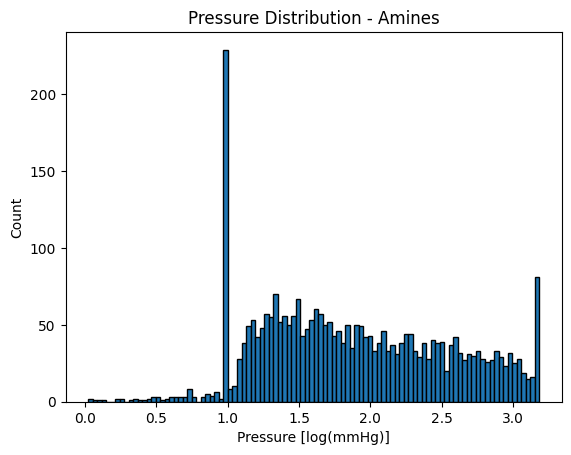

In [ ]:
df_amines_total = get_amines_from_data(total_dataset)
df_amines_train = get_amines_from_data(train_data)
df_amines_test = get_amines_from_data(test_data)

# Display size of the new dataframe with the amines -> Har totalt 555 aminer i datasettet.
print("Total amines:", df_amines_total.shape[0])
print("Train amines:", df_amines_train.shape[0])
print("Test amines:", df_amines_test.shape[0])
print("Fraction of amines in training data:", df_amines_train.shape[0] / df_amines_total.shape[0])

enter_folder("Code")
enter_folder("Data")

# Enter the folder
enter_folder(folder_name)

# Save the count of each atom type to a text file
with open("Amine Overview.txt", "w") as file:
    file.write("Amine Overview:\n")
    file.write(f"Total amines: {df_amines_total.shape[0]}\n")
    file.write(f"Train amines: {df_amines_train.shape[0]}\n")
    file.write(f"Test amines: {df_amines_test.shape[0]}\n")
    file.write(f"Fraction of amines in training data: {df_amines_train.shape[0] / df_amines_total.shape[0]}\n")

# Go back to the main folder
go_back_folder()
go_back_folder()

pressures, smiles_list, temperature_list = get_pressures_from_dataset(df_amines_total)

#pressures = [(10**pres)/760 for pres in pressures]

import matplotlib.pyplot as plt

# Plot the pressure distribution
plt.hist(pressures, bins=100, edgecolor='black')
plt.xlabel('Pressure [log(mmHg)]')
plt.ylabel('Count')
plt.title('Pressure Distribution - Amines')

plt.show()

# Save the amines in data folder 
enter_folder("Data")
df_amines_train.to_excel("Amines_train.xlsx", index=False)
df_amines_test.to_excel("Amines_test.xlsx", index=False)

# Go back to the main folder
go_back_folder()

Want to create a text file that contains information about the mean and std. Want one for the amines and for the general data. 

In [ ]:
"""
enter_folder("Data")

# Get the mean and standard deviation of the pressure in the training and test data for the amines
pressures, smiles_list, temperature_list = get_pressures_from_dataset(df_amines_train)
mean_pressure_train_amine = np.mean(pressures)
std_pressure_train_amine = np.std(pressures)

# Get the pressure values for the test data
pressures, smiles_list, temperature_list = get_pressures_from_dataset(df_amines_test)

# Calculate the mean and standard deviation of the pressure in the test data
mean_pressure_test_amine = np.mean(pressures)
std_pressure_test_amine = np.std(pressures)

# Save the mean and standard deviation of the pressure to a text file
with open("Pressure Overview (log).txt", "w") as file:
    file.write("Pressure Overview:\n")
    file.write(f"Mean pressure in training data: {mean_pressure_train_amine}\n")
    file.write(f"Standard deviation of pressure in training data: {std_pressure_train_amine}\n")
    file.write(f"Mean pressure in test data: {mean_pressure_test_amine}\n")
    file.write(f"Standard deviation of pressure in test data: {std_pressure_test_amine}\n")


go_back_folder()
"""

'\nenter_folder("Data")\n\n# Get the mean and standard deviation of the pressure in the training and test data for the amines\npressures, smiles_list, temperature_list = get_pressures_from_dataset(df_amines_train)\nmean_pressure_train_amine = np.mean(pressures)\nstd_pressure_train_amine = np.std(pressures)\n\n# Get the pressure values for the test data\npressures, smiles_list, temperature_list = get_pressures_from_dataset(df_amines_test)\n\n# Calculate the mean and standard deviation of the pressure in the test data\nmean_pressure_test_amine = np.mean(pressures)\nstd_pressure_test_amine = np.std(pressures)\n\n# Save the mean and standard deviation of the pressure to a text file\nwith open("Pressure Overview (log).txt", "w") as file:\n    file.write("Pressure Overview:\n")\n    file.write(f"Mean pressure in training data: {mean_pressure_train_amine}\n")\n    file.write(f"Standard deviation of pressure in training data: {std_pressure_train_amine}\n")\n    file.write(f"Mean pressure in te

In [ ]:
enter_folder("Data")
enter_folder(folder_name)

# Create a new folder that is called {number_of_temp} temperatures
if not os.path.exists(str(number_of_temp) + " temperatures"):
    os.mkdir(str(number_of_temp) + " temperatures")

    # Want to save the dataframes in this folder
    enter_folder(str(number_of_temp) + " temperatures")
    train_data.to_excel("Train.xlsx", index=False)
    test_data.to_excel("Test.xlsx", index=False)

    # Save the mean and standard deviation of the pressure to a text file
    with open("Pressure Overview (log).txt", "w") as file:
        file.write("Pressure Overview:\n")
        file.write(f"Mean pressure in training data: {mean_pressure_train}\n")
        file.write(f"Standard deviation of pressure in training data: {std_pressure_train}\n")
        file.write(f"Mean pressure in test data: {mean_pressure_test}\n")
        file.write(f"Standard deviation of pressure in test data: {std_pressure_test}\n")

    go_back_folder()

else: 
    print("Data at this temperature range already exists.")

go_back_folder()
go_back_folder()


Want to see if it helps the amine model to have 100 datapoints instead of just 7.

In [ ]:
# Load Amines_train.xlsx from the Data folder
train_data = pd.read_excel("Data/Amines_train.xlsx")

number_of_temp = 7

# Remove all the columns from T1 to T7
train_data = train_data.drop(columns=[f"T{i}" for i in range(1, number_of_temp + 1)])

# Define the number of temperature intervals
number_of_temp = 100

# Generate data from T1 to T100 
train_data, mean_pressure_train, std_pressure_train = calculate_pressure(train_data, number_of_temp)

# Save the data to a new file
train_data.to_excel("Data/Amines_train_new.xlsx", index=False)


/var/folders/sb/xp5jwlt55878lf0mfpdf0y2r0000gn/T/ipykernel_62061/1759490009.py:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.at[index, f"T{i+1}"] = f"P({temp}) = {log_pressure}"
/var/folders/sb/xp5jwlt55878lf0mfpdf0y2r0000gn/T/ipykernel_62061/1759490009.py:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.at[index, f"T{i+1}"] = f"P({temp}) = {log_pressure}"
